# Step 1: Build ML Dataset

This notebook extracts FFT features from all images and creates a CSV dataset for machine learning.

## What We'll Do:
1. Load all damaged and undamaged images
2. Extract 12 FFT features from each image
3. Label them (damaged=1, undamaged=0)
4. Save to CSV file

## Why These Features?
- **Statistical features (mean, std, skewness, kurtosis)**: Capture overall distribution
- **Frequency bands (low, high, ratio)**: Identify noise vs content
- **Radial profile**: Track how frequencies change from center to edge

**Damaged images** typically have:
- Higher high-frequency energy (scratches, noise)
- Higher energy ratio (more noise relative to signal)
- Irregular radial profile

## Setup

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

# Import our feature extractor
from src.ml.feature_extractor import extract_ml_features

print("✓ Imports successful!")
print(f"Project root: {project_root}")

✓ Imports successful!
Project root: d:\R&D Project\image_processing


## Define Paths

In [2]:
# Dataset paths
data_path = os.path.join(project_root, "data/raw/AI_for_Art_Restoration_2/paired_dataset_art")
damaged_dir = os.path.join(data_path, "damaged")
undamaged_dir = os.path.join(data_path, "undamaged")

# Output path
output_dir = os.path.join(project_root, "data/processed")
os.makedirs(output_dir, exist_ok=True)
output_csv = os.path.join(output_dir, "fft_features.csv")

# Check if directories exist
print(f"Damaged directory exists: {os.path.exists(damaged_dir)}")
print(f"Undamaged directory exists: {os.path.exists(undamaged_dir)}")

# Count files
damaged_files = [f for f in os.listdir(damaged_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
undamaged_files = [f for f in os.listdir(undamaged_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

print(f"\nFound {len(damaged_files)} damaged images")
print(f"Found {len(undamaged_files)} undamaged images")
print(f"Total: {len(damaged_files) + len(undamaged_files)} images")

Damaged directory exists: True
Undamaged directory exists: True

Found 114 damaged images
Found 114 undamaged images
Total: 228 images


## Extract Features from All Images

This will take a few minutes depending on how many images you have.

**What's happening:**
- Loop through each image
- Apply FFT transform
- Extract 12 features
- Store in list with label

In [3]:
# Lists to store features and labels
all_features = []
all_labels = []
all_filenames = []
feature_names = None

print("Processing damaged images...")
for filename in tqdm(damaged_files):
    try:
        path = os.path.join(damaged_dir, filename)
        features, names = extract_ml_features(path)
        
        all_features.append(features)
        all_labels.append(1)  # 1 = damaged
        all_filenames.append(filename)
        
        if feature_names is None:
            feature_names = names
            
    except Exception as e:
        print(f"Error processing {filename}: {e}")

print("\nProcessing undamaged images...")
for filename in tqdm(undamaged_files):
    try:
        path = os.path.join(undamaged_dir, filename)
        features, names = extract_ml_features(path)
        
        all_features.append(features)
        all_labels.append(0)  # 0 = undamaged
        all_filenames.append(filename)
        
    except Exception as e:
        print(f"Error processing {filename}: {e}")

print(f"\n✓ Successfully processed {len(all_features)} images")

Processing damaged images...


100%|██████████| 114/114 [00:46<00:00,  2.46it/s]



Processing undamaged images...


100%|██████████| 114/114 [00:45<00:00,  2.53it/s]


✓ Successfully processed 228 images


## Create DataFrame and Save to CSV

In [4]:
# Convert to DataFrame
df = pd.DataFrame(all_features, columns=feature_names)
df['label'] = all_labels
df['filename'] = all_filenames

# Reorder columns (put filename and label first)
cols = ['filename', 'label'] + feature_names
df = df[cols]

# Save to CSV
df.to_csv(output_csv, index=False)

print(f"✓ Saved dataset to: {output_csv}")
print(f"\nDataset shape: {df.shape}")
print(f"Features: {len(feature_names)}")
print(f"Samples: {len(df)}")

✓ Saved dataset to: d:\R&D Project\image_processing\data/processed\fft_features.csv

Dataset shape: (228, 16)
Features: 14
Samples: 228


## Preview the Dataset

In [5]:
# Show first few rows
print("First 5 rows:")
display(df.head())

# Show label distribution
print("\nLabel distribution:")
print(df['label'].value_counts())
print(f"\n0 = Undamaged: {(df['label']==0).sum()} images")
print(f"1 = Damaged: {(df['label']==1).sum()} images")

First 5 rows:


,filename,label,mean,std_dev,skewness,kurtosis,low_freq_energy,high_freq_energy,energy_ratio,radial_center,radial_25,radial_50,radial_75,radial_edge,color_balance_need,sharpening_need
0,1.png,1,172.078791,24.651689,0.419049,0.405692,282.272820,172.033401,0.609458,418.130939,214.490409,198.176288,178.011499,163.603976,0.077168,0.405136
1,10.png,1,170.703457,18.225493,0.014498,1.529401,219.883419,170.090076,0.773547,350.153997,194.418368,178.976622,173.541926,166.637158,0.077604,0.000000
2,100.png,1,144.019931,21.890683,0.278796,1.180011,187.940305,142.386107,0.757613,324.060618,174.719671,160.692192,151.347043,138.558214,0.412804,0.000000
3,101.jpg,1,135.630466,26.014150,0.708370,0.983259,208.361504,134.742889,0.646678,340.211703,177.165557,160.283772,140.546631,127.639632,0.124929,0.000000
4,102.jpg,1,147.370054,26.402196,0.469758,0.694385,220.423909,146.272710,0.663597,346.065468,194.342055,169.853374,150.250020,137.117490,0.067642,0.178267



Label distribution:
label
1    114
0    114
Name: count, dtype: int64

0 = Undamaged: 114 images
1 = Damaged: 114 images


## Basic Statistics

Let's see if damaged and undamaged images have different feature values.

In [6]:
# Compare damaged vs undamaged
damaged_df = df[df['label'] == 1]
undamaged_df = df[df['label'] == 0]

print("Feature Comparison (Damaged vs Undamaged)")
print("=" * 70)
print(f"{'Feature':<20} {'Damaged (mean)':>15} {'Undamaged (mean)':>18} {'Difference':>12}")
print("-" * 70)

for feature in feature_names:
    damaged_mean = damaged_df[feature].mean()
    undamaged_mean = undamaged_df[feature].mean()
    diff = damaged_mean - undamaged_mean
    
    print(f"{feature:<20} {damaged_mean:>15.4f} {undamaged_mean:>18.4f} {diff:>12.4f}")

print("\n💡 Key Observations:")
print("   Look for features with large differences - these are most useful for classification!")
print("   Typically:")
print("   - high_freq_energy: Higher for damaged (scratches/noise)")
print("   - energy_ratio: Higher for damaged (more noise relative to signal)")

Feature Comparison (Damaged vs Undamaged)
Feature               Damaged (mean)   Undamaged (mean)   Difference
----------------------------------------------------------------------
mean                        146.6168           144.9092       1.7075
std_dev                      23.1671            23.4102      -0.2431
skewness                      0.4080             0.5185      -0.1105
kurtosis                      1.1539             1.3950      -0.2411
low_freq_energy             208.0523           210.8120      -2.7597
high_freq_energy            145.3979           143.5702       1.8277
energy_ratio                  0.7030             0.6849       0.0180
radial_center               337.8102           336.8703       0.9399
radial_25                   184.5458           184.5513      -0.0056
radial_50                   164.7903           163.0859       1.7044
radial_75                   150.2588           147.8831       2.3757
radial_edge                 139.3286           137.2868    

## Visualize Feature Distributions

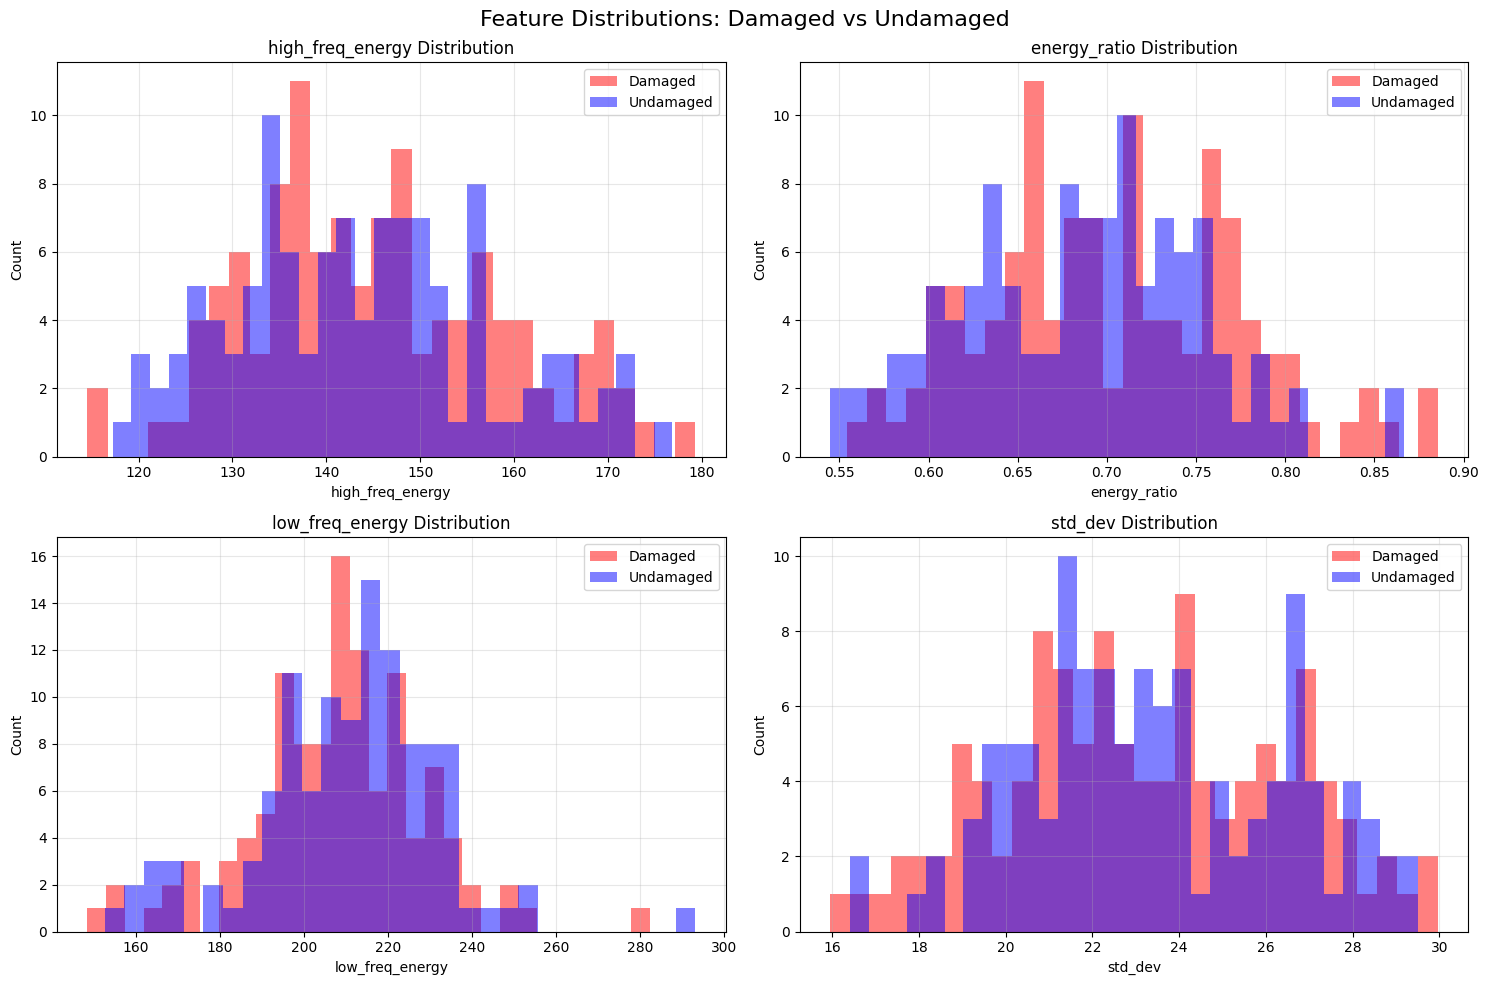


💡 Interpretation:
   - If histograms are well-separated → feature is good for classification
   - If histograms overlap heavily → feature is less useful


In [7]:
import matplotlib.pyplot as plt

# Plot distributions of key features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Feature Distributions: Damaged vs Undamaged', fontsize=16)

key_features = ['high_freq_energy', 'energy_ratio', 'low_freq_energy', 'std_dev']

for idx, feature in enumerate(key_features):
    ax = axes[idx // 2, idx % 2]
    
    ax.hist(damaged_df[feature], bins=30, alpha=0.5, label='Damaged', color='red')
    ax.hist(undamaged_df[feature], bins=30, alpha=0.5, label='Undamaged', color='blue')
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.set_title(f'{feature} Distribution')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   - If histograms are well-separated → feature is good for classification")
print("   - If histograms overlap heavily → feature is less useful")

## Summary

✅ **What We Accomplished:**
1. Extracted 12 FFT features from all images
2. Created labeled dataset (damaged=1, undamaged=0)
3. Saved to CSV for ML training
4. Visualized feature distributions

📊 **Dataset Ready!**
- File: `data/processed/fft_features.csv`
- Features: 12 per image
- Labels: Binary (damaged/undamaged)

🎯 **Next Step:**
Open notebook `2_train_classifier.ipynb` to train a machine learning model!